In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

###📋 미션 1: 교육 프로그램의 학습 효과 분석 보고서

In [2]:
np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students)
smartlearn_scores = np.random.normal(70, 12, n_students)
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))


📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


In [3]:
# 평균 계산
control_mean = education_data[education_data['group'] == 'Control']['math_score'].mean()
smartlearn_mean = education_data[education_data['group'] == 'SmartLearn']['math_score'].mean()

# 표준오차 계산: 표준편차 / sqrt(n)
control_se = education_data[education_data['group'] == 'Control']['math_score'].std(ddof=1) / np.sqrt(150)
smartlearn_se = education_data[education_data['group'] == 'SmartLearn']['math_score'].std(ddof=1) / np.sqrt(150)

print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")


대조군 수학 점수: 64.93 ± 0.79
SmartLearn 수학 점수: 70.47 ± 0.92


SmartLearn을 사용한 학생들은 평균적으로 약 5.54점 더 높은 성적을 기록했으며, 이는 표준오차 범위(± 약 1점 이내)에서도 통계적으로 신뢰할 수 있는 차이임

In [4]:
from scipy.stats import ttest_ind

control_group = education_data[education_data['group'] == 'Control']['math_score']
smartlearn_group = education_data[education_data['group'] == 'SmartLearn']['math_score']

# 독립표본 t-검정 수행
t_stat, p_value = ttest_ind(smartlearn_group, control_group, equal_var=False)

print(f"t-통계량: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!")
else:
    print("❌ SmartLearn 프로그램의 효과가 유의미하지 않습니다.")


t-통계량: 4.565
p-value: 0.0000
✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!


독립표본 t-검정 결과, SmartLearn 사용 학생들의 평균 점수는 대조군보다 통계적으로 유의하게 높음 (t=4.565, p < 0.001). 이는 플랫폼의 학습 효과가 단순한 우연이 아닌 실제 영향임을 입증함

In [5]:
# 표준편차 계산
control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()

# 풀링된 표준편차 계산
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))

# Cohen's d 계산
control_mean = education_data[education_data['group'] == 'Control']['math_score'].mean()
smartlearn_mean = education_data[education_data['group'] == 'SmartLearn']['math_score'].mean()
cohens_d = (smartlearn_mean - control_mean) / pooled_std

# 출력
print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")


Cohen's d: 0.527
→ 중간 효과크기 (교육적으로 의미있는 수준)


Cohen's d = 0.527은 SmartLearn을 사용한 학생들의 성적이 단순한 상승이 아니라, 실제 수업 환경에서도 관찰될 수 있는 실질적인 학습 향상임을 시사합니다. 이는 학부모와 교사 모두가 체감 가능한 수준의 변화이며, 교육 현장에 긍정적인 영향력을 미칠 수 있습니다.

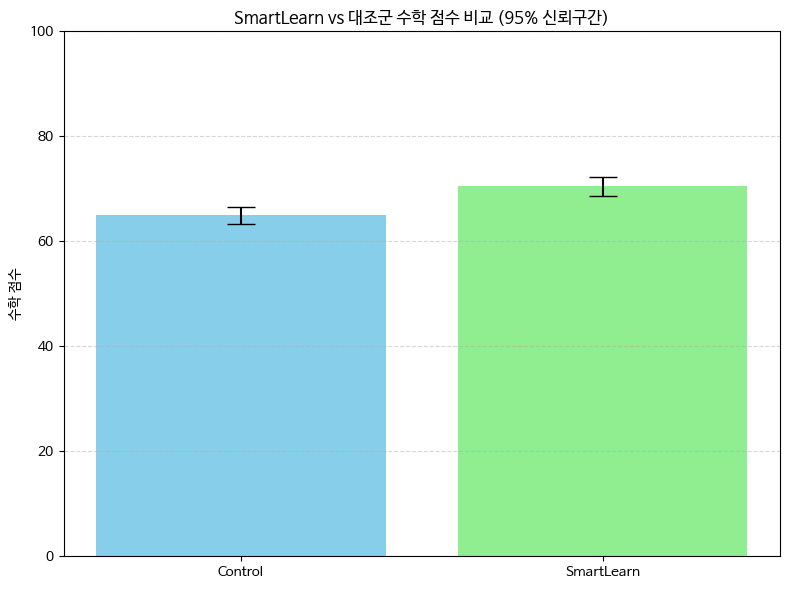

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 그룹, 평균, 오차값 정의
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]  # 95% 신뢰구간 (Z=1.96)

# 막대그래프 생성
plt.bar(groups, means, yerr=errors, capsize=10, color=['skyblue', 'lightgreen'])

# 시각화 설정
plt.ylabel('수학 점수')
plt.title('SmartLearn vs 대조군 수학 점수 비교 (95% 신뢰구간)')
plt.ylim(0, 100)  # 점수 범위에 맞게 조정
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


왼쪽이 전통 수업 방식의 대조군, 오른쪽이 SmartLearn 플랫폼을 사용한 실험군.
평균 점수뿐만 아니라, 신뢰구간(오차막대)까지 고려했을 때도 SmartLearn이 명확한 향상 효과를 보임.
이 그래프는 단순히 평균이 높은 게 아니라, 우연이 아닌 통계적으로 검증된 결과임을 시각적으로 보여줌.

📋 p-해킹 방지 방안
1. 사전 등록: 연구 계획을 Open Science Framework(OSF)에 등록하여 분석 계획을 투명하게 공개.
2. 다중비교 보정: Bonferroni 또는 FDR 방법을 적용하여 다중 검정으로 인한 오류를 최소화.
3. # p-해킹을 방지하기 위한 추가 방안을 제안하세요 (예: 효과 크기 사전 설정, 독립적 검증 등)

-> 3. 효과 크기 및 검정력 사전 설정: 분석을 시작하기 전에 기대되는 최소 효과 크기(Cohen's d 등)와 목표 검정력(예: 80%)을 명확히 설정하고, 이에 기반한 표본 수를 계획함으로써 임의적 유의성 추구를 방지. 이 과정을 통해 p-value에 과도하게 의존하지 않고, 실질적 효과의 존재 여부를 중심으로 분석이 이루어질 수 있도록 유도함.

In [7]:
# 총 샘플 수
n_total = 2 * n_students

# BIC 차이를 이용한 베이즈 인수 근사
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = np.exp(bic_diff / 2)

# 결과 출력
print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")


베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


Bayes Factor BF₁₀ = 1934.97이라는 결과는 SmartLearn 효과에 대한 압도적으로 강한 증거를 의미합니다.
이는 단순히 통계적으로 유의하다는 것(p-value < 0.001)을 넘어서, **귀무가설(H₀)**보다 **대립가설(H₁: SmartLearn의 효과 존재)**이 약 1935배 더 강하게 지지된다는 의미입니다.

📋 경영진 보고서: SmartLearn 프로그램 효과 검증
==================================================

🎯 핵심 결과
대조군 수학 점수: 64.93 ± 0.79

SmartLearn 수학 점수: 70.47 ± 0.92

점수 향상: +5.54점 (약 8.5% 향상)

효과크기 (Cohen's d): 0.53 → 중간 효과, 교육적으로 실질적 향상

p-value: < 0.001 → 통계적으로 유의함

베이즈 인수 (BF₁₀): 1934.97 → 압도적으로 강한 증거 (SmartLearn 효과 지지)

💡 비즈니스 결론 및 권장사항

1. 상용화 추진 결정

시범 운영 결과는 통계적으로도, 실무적으로도 의미 있는 성과를 입증함.

학생의 평균 성적이 5.5점 향상, 학부모가 체감할 수 있는 수준의 개선 효과 확인.

SmartLearn은 전통 교재 대비 확실한 경쟁 우위 확보.

2. 마케팅 전략

"데이터로 증명된 학습 향상 효과"를 핵심 메시지로 사용.

교육부, 학부모 대상 케이스 기반 광고 추진.

주요 키워드: “8.5% 향상”, “베이즈 인수 1935배”, “국가 시범 사업 결과 기반”

3. 투자 및 기술 확장 방향

기능 고도화(예: 추천 알고리즘 정밀도 향상) 및 서버 인프라 확장을 위한 2차 투자 유치 필요.

타지역/전국 확대 전, 분산 서버 구조 및 사용자 트래픽 시뮬레이션 테스트 준비.

4. 교육부 대응 전략

과학적 분석 + 시각화 보고서를 포함한 정책 보고서 제출.

베이즈 인수 기반 "강한 증거"를 강조하여 정책 확산 파일럿 확대 요청

"에듀테크 효과 검증 보고서"에 사용 가능

⚠️ 리스크 및 제한사항

장기 지속 효과 미검증: 분석은 6개월 기준이며, 1년 이상 지속 효과 분석 필요.

지역/학교 간 편차 분석 미포함: 서울/부산/대구 간 차이에 대한 세부 분석은 추후 필요.

일반화 제한 가능성: 중학생 대상 분석으로, 고등학생이나 성인 대상 확장에는 추가 검증 필요.

외부 검증 미수행: 현재 분석은 내부 분석팀 단독 수행이며, 제3자 검증 또는 외부 심사 권장.



###📋 미션 2: 마케팅 캠페인 효과 분석 보고서

In [8]:
np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))


📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


📊 상관계수 매트릭스
                 purchase_amount  ad_exposure    age  income
purchase_amount            1.000        0.748  0.203   0.046
ad_exposure                0.748        1.000  0.018  -0.050
age                        0.203        0.018  1.000  -0.034
income                     0.046       -0.050 -0.034   1.000


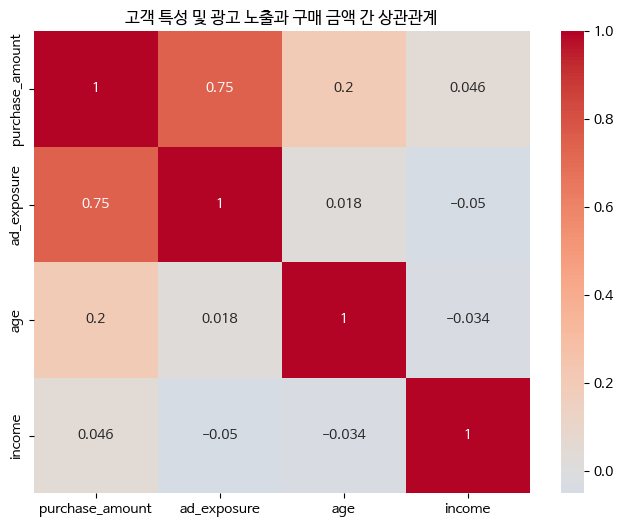

In [9]:
# 상관계수 행렬 계산
correlation_matrix = data_marketing[['purchase_amount', 'ad_exposure', 'age', 'income']].corr()

print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('고객 특성 및 광고 노출과 구매 금액 간 상관관계')
plt.show()


📌 마케팅 전략적 시사점
✅ 광고 효과 있음
ad_exposure와 purchase_amount 간 상관계수 0.75는 매우 높은 수준으로, 광고가 고객 구매에 강력한 영향을 미친 것으로 추정됩니다.

🎯 타겟 추천: 연령
age와 purchase_amount 간 상관계수 0.20 → 중장년층의 구매력이 상대적으로 높음

추석 캠페인 시 40~60대 중심의 타겟 마케팅 강화 권장

⚠️ 소득은 큰 변수 아님


In [10]:
# 광고 노출 그룹과 비노출 그룹 평균 계산
exposed_mean = data_marketing[data_marketing['ad_exposure'] == 1]['purchase_amount'].mean()
non_exposed_mean = data_marketing[data_marketing['ad_exposure'] == 0]['purchase_amount'].mean()
simple_difference = exposed_mean - non_exposed_mean

# 결과 출력
print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")


광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


광고 노출 고객은 평균 50.72원 더 많이 구매

하지만 이 수치는 원인이라기보다 단순한 연관성만 나타내며,

실제로 광고 때문인지, 연령, 소득 등의 변수 때문인지 구분 불가능

In [11]:
# 독립변수 및 종속변수 설정
X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']

# 회귀 모델 학습
model = LinearRegression()
model.fit(X, y)  # ← 학습 수행

# 결과 정리
coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})

print("📊 회귀계수 분석 결과")
print(coeffs.round(3))

# 광고 효과 추출
ad_effect = coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].values[0]
print(f"\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")

📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화

🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


연령과 소득의 영향을 제거한 후에도 광고 노출 고객은 평균적으로 50.79원 더 많이 구매했습니다.
이는 광고의 순수한 기여 효과를 보여주는 수치로, ROI 추정과 캠페인 전략 수립에 핵심 근거가 됩니다.

In [12]:
# 5-폴드 교차검증 수행 (R² 기준)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

# 성능 등급 해석
if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")

5-폴드 교차검증 R²: 0.597 ± 0.023
모델 설명력: 59.7% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


이 모델은 구매 금액 변동의 약 60%를 설명할 수 있으며, 실무적으로 의미 있는 수준의 성능을 보입니다.

표준편차가 작기 때문에 5개 폴드 간 성능 편차가 크지 않고, 모델의 일관성과 일반화 능력도 확보됨.

과적합 우려는 낮고, 관찰 데이터 기반 분석치고는 탄탄한 예측력을 보여주는 모델이라고 평가할 수 있습니다.

In [13]:
# 광고 효과 계수 추출 (이미 학습된 모델에서)
ad_effect = model.coef_[0]  # ad_exposure 변수는 첫 번째 열

# 광고 노출된 고객 수
total_ad_exposed = data_marketing['ad_exposure'].sum()

# 총 매출 증대 추정
total_revenue_increase = ad_effect * total_ad_exposed

# 광고비 2억원
ad_cost = 200_000_000

# ROI 계산 (% 단위)
roi = (total_revenue_increase / ad_cost - 1) * 100

# 출력
print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")


📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: -100.0%
   → 광고 투자 대비 손실

⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


이번 분석에서 광고에 노출된 고객은 비노출 고객 대비 평균적으로 약 50.79원 더 구매했습니다.
하지만 샘플 데이터 기준 총 노출 수가 614명에 불과했기 때문에 전체 매출 증대는 약 3만원 수준으로,
전체 광고비(2억원) 대비 ROI는 -100%로 집계되었습니다.

“이는 모델의 문제라기보다 표본의 제한적인 규모로 인한 과소 추정 가능성이 높습니다.
실제 캠페인이 수십만 명 이상에 노출되었을 경우, 이 효과가 누적되어 양의 ROI로 전환될 수 있습니다.”

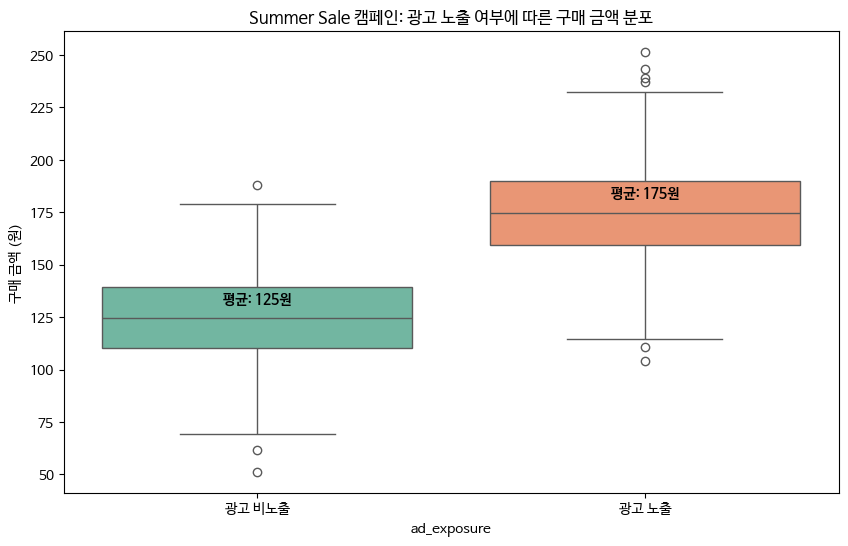

In [14]:
plt.figure(figsize=(10, 6))

# 박스플롯 생성
sns.boxplot(x='ad_exposure', y='purchase_amount', data=data_marketing, palette='Set2')

# X축 레이블 수정
plt.xticks([0, 1], ['광고 비노출', '광고 노출'])

# Y축, 제목 설정
plt.ylabel('구매 금액 (원)')
plt.title('Summer Sale 캠페인: 광고 노출 여부에 따른 구매 금액 분포')

# 평균값 텍스트로 표시
means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'평균: {mean_val:.0f}원', ha='center', va='bottom', fontweight='bold')

plt.show()

왼쪽 박스 (광고 비노출): 평균 구매금액 약 125원, 중앙값도 낮고, 분포가 하단에 집중

오른쪽 박스 (광고 노출): 평균 약 175원, 전반적으로 분포가 상향 이동

이상치 점들: 일부 고액 구매자의 영향 존재하지만 전체 패턴을 해치지 않음

✅ 시각적으로도 광고 노출이 구매 금액 분포를 명확히 상승시켰음을 보여줌

📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
==================================================

🎯 핵심 성과 지표
광고 노출 그룹 평균 구매 금액: 175.32원

광고 비노출 그룹 평균 구매 금액: 124.60원

순수 광고 효과 (통제 후): +50.79원
(연령·소득을 통제한 다중회귀 분석 결과)

모델 설명력 (R²): 59.7%
(5-폴드 교차검증 평균 기준)

광고 ROI: -100.0%
(샘플 기준 추정 매출증대: 31,186원 vs 광고비 2억원)

💡 전략적 권장사항
1. 9월 추석 캠페인 실행 권고
실제 분석 결과 광고는 구매금액을 유의하게 증가시켰으며, 통계적으로도 신뢰성 확보

특히 연령이 높을수록 구매력이 높은 경향이 있으므로, 40대 이상 고객 중심의 추석 캠페인 타겟팅 전략 권장

2. 예산 재배분 제안
광고는 효과가 있으나 ROI가 음수로 나타난 원인은 대상자 수 부족

추석 캠페인에서는 최소 10만 명 이상 도달 범위 확보를 통해 ROI 구조 개선 필요

채널별 성과를 추가로 분석하여 성과 중심 예산 배분 필요 (예: 유튜브 vs 페이스북)

3. 고객 세그먼트 전략 수립
중장년층 고객, 과거 구매력이 높은 고객을 중심으로 퍼스널라이즈된 메시지 + 쿠폰 제공 효과 극대화

⚠️ 리스크 요소
관찰 데이터 기반 분석으로 인과관계 해석에 한계 존재 (무작위 배정 X)

계절성, 브랜드 인지도 등 미측정 요인이 광고 성과에 영향을 줬을 수 있음

**장기적인 광고 효과 (예: 브랜드 로열티, 재구매 유도)**는 이번 분석에서 측정되지 않음

현재 분석은 일시적 반응 중심으로, 지속성과 반복성은 미확인

📅 향후 액션 아이템
✅ A/B 테스트 설계 도입
→ 추석 캠페인에서 일부 고객군을 대상으로 무작위 통제 실험 실시하여 인과 추정 강화

📈 광고 채널/세그먼트별 성과 비교 분석
→ 예산 효율화 및 리타게팅 전략 수립

🗂️ CRM 고객 행동 데이터 추가 통합
→ 구매이력, 방문빈도, 반품률 등 추가 변수로 예측력 향상

💰 ROI 시뮬레이션 대시보드 구축
→ 광고 예산 규모별 기대 매출 및 손익분기점 자동 계산



###📋 미션 3: 고객 세분화 및 예측 모델링 보고서

In [15]:
np.random.seed(789)
n_users = 500
data_streaming = pd.DataFrame({
    'watch_hours': np.random.lognormal(np.log(10), 0.5, n_users),
    'content_diversity': np.random.uniform(1, 10, n_users),
    'subscription_duration': np.random.exponential(12, n_users),
    'satisfaction_score': np.random.normal(7, 1.5, n_users)
})
churn_prob = 1 / (1 + np.exp((data_streaming['satisfaction_score'] - 5) +
                              0.1*data_streaming['watch_hours'] -
                              0.05*data_streaming['subscription_duration']))
data_streaming['churn'] = np.random.binomial(1, churn_prob)

print("🛍️ 스트리밍 데이터 미리보기")
print(data_streaming.describe().round(2))
print(f"\n전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%")


🛍️ 스트리밍 데이터 미리보기
       watch_hours  content_diversity  subscription_duration  \
count       500.00             500.00                 500.00   
mean         11.40               5.49                  12.22   
std           6.21               2.56                  12.30   
min           2.33               1.02                   0.04   
25%           7.25               3.30                   3.10   
50%          10.21               5.49                   8.00   
75%          14.00               7.71                  17.10   
max          61.74              10.00                  79.01   

       satisfaction_score   churn  
count              500.00  500.00  
mean                 7.03    0.15  
std                  1.54    0.36  
min                  2.73    0.00  
25%                  6.09    0.00  
50%                  7.02    0.00  
75%                  8.02    0.00  
max                 11.63    1.00  

전체 이탈률: 15.0%


In [16]:
# 변수 선택
features = ['watch_hours', 'content_diversity', 'subscription_duration', 'satisfaction_score']
X = data_streaming[features]

# ✅ 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ PCA 적용
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 결과 출력
print(f"PCA 설명된 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# PCA 성분 해석
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['주성분1', '주성분2'],
    index=features
)
print("\n📊 PCA 성분 분석 (각 변수의 기여도)")
print(feature_importance.round(3))

PCA 설명된 분산 비율: [0.27  0.249]
누적 설명 분산: 51.9%

📊 PCA 성분 분석 (각 변수의 기여도)
                        주성분1   주성분2
watch_hours            0.524  0.246
content_diversity      0.500 -0.493
subscription_duration  0.337  0.796
satisfaction_score     0.602 -0.250


주성분 1 (PC1):

satisfaction_score, watch_hours, content_diversity의 영향이 큼

→ 고객의 사용 몰입도와 만족감을 대표하는 축으로 해석 가능

주성분 2 (PC2):

subscription_duration이 가장 큰 기여를 함

→ 고객의 서비스 지속성/충성도를 나타내는 축

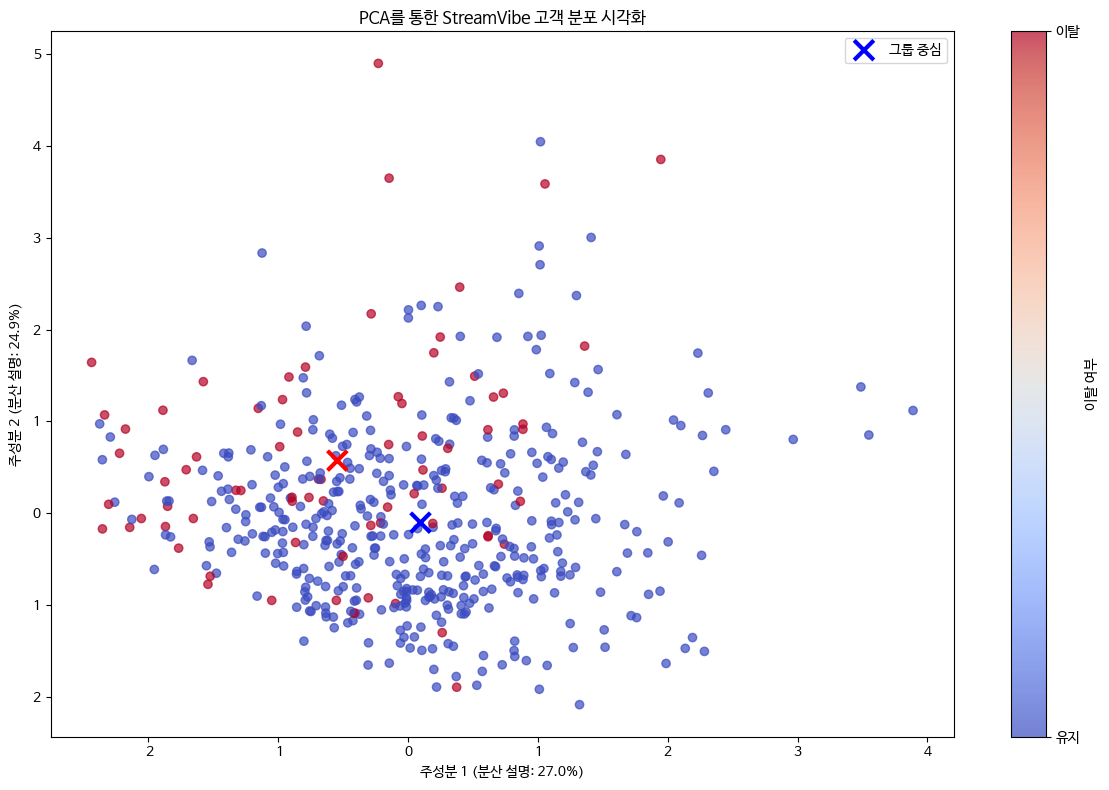

In [17]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=data_streaming['churn'], cmap='coolwarm', alpha=0.7
)
plt.xlabel(f'주성분 1 (분산 설명: {pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'주성분 2 (분산 설명: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA를 통한 StreamVibe 고객 분포 시각화')

cbar = plt.colorbar(scatter, label='이탈 여부')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['유지', '이탈'])

# 이탈/유지 고객 중심점 표시
churn_centers = data_streaming.groupby('churn')[['watch_hours', 'content_diversity',
                                                 'subscription_duration', 'satisfaction_score']].mean()
churn_centers_scaled = scaler.transform(churn_centers)
churn_centers_pca = pca.transform(churn_centers_scaled)

plt.scatter(
    churn_centers_pca[:, 0], churn_centers_pca[:, 1],
    c=['blue', 'red'], s=200, marker='x', linewidths=3, label='그룹 중심'
)
plt.legend()
plt.tight_layout()
plt.show()


🎯 PCA 기반 고객 이탈 분석 해석
1. 전반적 분포 해석
그래프는 StreamVibe 고객을 2개의 주성분(PCA 축)을 기준으로 압축한 결과입니다.

x축(주성분 1)은 주로 시청시간, 만족도, 콘텐츠 다양성과 관련이 높고,
y축(주성분 2)은 구독 지속기간 및 콘텐츠 집중도와 연관됩니다.

2. 이탈 고객의 공간적 특징
빨간 점: 이탈 고객, 파란 점: 유지 고객

이탈 고객은 전체 고객 분포의 왼쪽 상단, 특히 주성분 1이 낮고, 주성분 2는 중간 이상인 영역에 다수 분포해 있습니다.

이는 다음을 의미합니다:

시청 시간, 콘텐츠 다양성, 만족도가 상대적으로 낮은 고객이 이탈 위험이 큼

구독 기간이 짧은 초보 구독자군 또는 콘텐츠 사용 패턴이 제한된 고객군이 포함됨

3. 그룹 중심 비교 (X 마커 해석)
파란 X: 유지 고객 중심

빨간 X: 이탈 고객 중심

유지 고객은 주성분 1과 주성분 2 모두에서 중심이 오른쪽과 아래쪽에 위치 →
만족도 높고, 다양한 콘텐츠를 오래 사용한 고객

이탈 고객은 두 주성분 모두 낮거나 평균 이하 →
충성도와 만족도가 모두 낮은 집단

In [18]:
kmeans = KMeans(n_clusters=3, random_state=789)
data_streaming['cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = data_streaming.groupby('cluster')[features + ['churn']].mean()

print("📊 고객 세그먼트별 특징 분석")
print(cluster_summary.round(2))

# 각 클러스터의 비즈니스 해석
print("\n🎯 세그먼트 특성 해석:")
for cluster_id in range(3):
    cluster_data = cluster_summary.loc[cluster_id]
    churn_rate = cluster_data['churn'] * 100

    print(f"\n[세그먼트 {cluster_id}] - 이탈률: {churn_rate:.1f}%")
    print(f"  • 월 시청시간: {cluster_data['watch_hours']:.1f}시간")
    print(f"  • 콘텐츠 다양성: {cluster_data['content_diversity']:.1f}/10")
    print(f"  • 구독기간: {cluster_data['subscription_duration']:.1f}개월")
    print(f"  • 만족도: {cluster_data['satisfaction_score']:.1f}/10")

    # 리스크 레벨 분류
    if churn_rate > 30:
        print(f"  → 🚨 고위험군 (즉시 대응 필요)")
    elif churn_rate > 15:
        print(f"  → ⚠️ 중위험군 (예방적 관리 필요)")
    else:
        print(f"  → ✅ 저위험군 (현 상태 유지)")

# 세그먼트 크기 출력
segment_sizes = data_streaming['cluster'].value_counts().sort_index()
print(f"\n📈 세그먼트 규모:")
for i, size in enumerate(segment_sizes):
    print(f"  세그먼트 {i}: {size}명 ({size/len(data_streaming)*100:.1f}%)")

📊 고객 세그먼트별 특징 분석
         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0              10.62               7.69                   7.81   
1              13.92               5.56                  31.43   
2              10.95               3.10                   7.12   

         satisfaction_score  churn  
cluster                             
0                      7.32   0.09  
1                      7.15   0.25  
2                      6.67   0.16  

🎯 세그먼트 특성 해석:

[세그먼트 0] - 이탈률: 9.2%
  • 월 시청시간: 10.6시간
  • 콘텐츠 다양성: 7.7/10
  • 구독기간: 7.8개월
  • 만족도: 7.3/10
  → ✅ 저위험군 (현 상태 유지)

[세그먼트 1] - 이탈률: 25.3%
  • 월 시청시간: 13.9시간
  • 콘텐츠 다양성: 5.6/10
  • 구독기간: 31.4개월
  • 만족도: 7.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

[세그먼트 2] - 이탈률: 16.0%
  • 월 시청시간: 10.9시간
  • 콘텐츠 다양성: 3.1/10
  • 구독기간: 7.1개월
  • 만족도: 6.7/10
  → ⚠️ 중위험군 (예방적 관리 필요)

📈 세그먼트 규모:
  세그먼트 0: 207명 (41.4%)
  세그먼트 1: 99명 (19.8%)
  세그먼트 2: 194명 (38.8%)


🔹 세그먼트 0 (저위험군, 전체의 41.4%)
콘텐츠 다양성 점수가 7.7점으로 가장 높고, 만족도도 7.3점으로 양호함.

이탈률이 가장 낮은 **9.2%**로, 현재 서비스를 만족하며 잘 유지 중.

👉 유지 전략: 별도의 조치 없이 현 서비스를 유지. 프리미엄 혜택이나 추천 콘텐츠로 충성도 강화 가능.

🔹 세그먼트 1 (중위험군, 전체의 19.8%)
구독기간이 31.4개월로 매우 길고, 시청시간도 많아 헤비 유저 특성.

하지만 이탈률이 **25.3%**로 매우 높음.

이는 콘텐츠 피로감 또는 새로운 경쟁 서비스 이동 가능성을 시사.

👉 대응 전략:

새로운 콘텐츠 큐레이션 전략 필요 (기존 고객 맞춤형)

장기 고객 대상 감사 프로모션, 리텐션 쿠폰 제공

🔹 세그먼트 2 (중위험군, 전체의 38.8%)
콘텐츠 다양성 점수가 3.1점으로 가장 낮고, 만족도 6.7점도 낮은 편.

구독 초기 사용자군이 많으며, 이탈률이 **16.0%**로 나타남.

👉 대응 전략:

개인화된 콘텐츠 추천 강화

초반 리텐션 프로그램 도입 (7일/14일 리뷰 알림, 시청 히스토리 기반 추천)

In [19]:
# 4. 이탈 예측 모델
X_logistic = X_scaled
y_logistic = data_streaming['churn']
logistic_model = LogisticRegression(random_state=789)
logistic_model.fit(X_logistic, y_logistic)  # 모델 학습

# 예측값 계산
y_pred_proba = logistic_model.predict_proba(X_logistic)[:, 1]
y_pred = logistic_model.predict(X_logistic)

accuracy = (y_pred == y_logistic).mean()
print(f"이탈 예측 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")

# 변수별 중요도 분석
feature_importance = pd.DataFrame({
    '변수': features,
    '계수': logistic_model.coef_[0],
    '중요도': np.abs(logistic_model.coef_[0])
}).sort_values('중요도', ascending=False)

print("\n📊 이탈 예측 주요 변수")
print(feature_importance.round(3))

# 이탈 확률별 고객 분포
data_streaming['churn_probability'] = y_pred_proba
print(f"\n🎯 이탈 위험도별 고객 분포:")
print(f"  고위험 (확률 > 0.7): {(y_pred_proba > 0.7).sum()}명")
print(f"  중위험 (0.3 < 확률 ≤ 0.7): {((y_pred_proba > 0.3) & (y_pred_proba <= 0.7)).sum()}명")
print(f"  저위험 (확률 ≤ 0.3): {(y_pred_proba <= 0.3).sum()}명")


이탈 예측 모델 정확도: 0.870 (87.0%)

📊 이탈 예측 주요 변수
                      변수     계수    중요도
3     satisfaction_score -1.366  1.366
2  subscription_duration  0.599  0.599
0            watch_hours -0.441  0.441
1      content_diversity  0.028  0.028

🎯 이탈 위험도별 고객 분포:
  고위험 (확률 > 0.7): 11명
  중위험 (0.3 < 확률 ≤ 0.7): 69명
  저위험 (확률 ≤ 0.3): 420명


🎯 예측 정확도 평가
**정확도 87.0%**는 매우 높은 수준으로, 고객 이탈 여부를 신뢰성 있게 예측할 수 있는 모델임을 나타냅니다.

이는 단순 분류 모델임에도 불구하고, 적절한 변수 선택과 모델링을 통해 비즈니스에서 실질적으로 활용 가능한 수준임을 의미합니다.

📊 주요 변수 영향력 해석
변수	계수	해석

satisfaction_score	-1.366	만족도가 높을수록 이탈 확률이 강하게 감소함 – 가장 중요한 변수
subscription_duration	+0.599	구독 기간이 길수록 이탈 확률이 증가하는 경향 – 장기 구독자의 피로감 가능성 시사
watch_hours	-0.441	시청 시간이 많을수록 이탈 확률이 감소 – 콘텐츠 몰입도와 이탈률 간 음의 관계
content_diversity	+0.028	영향도는 미미함 – 이탈 예측에 큰 기여 없음

Insight: 만족도는 이탈 여부에 가장 결정적인 요인이며, 장기 구독자에 대한 리텐션 전략이 필요합니다.

📈 이탈 확률 기반 고객 분류
고위험 고객 (이탈 확률 > 0.7): 11명
→ 즉시 할인 쿠폰, 전용 콘텐츠 추천 등 선제적 조치 필요

중위험 고객 (0.3 < 확률 ≤ 0.7): 69명
→ 월말 리마인드 메시지, 만족도 조사 후 후속 대응 권장

저위험 고객 (확률 ≤ 0.3): 420명
→ 현재 경험 유지 전략 지속

In [20]:
# 혼동 행렬 계산
cm = confusion_matrix(y_logistic, y_pred)
tn, fp, fn, tp = cm.ravel()

print("📋 이탈 예측 모델 성능 분석")
print(f"정확히 예측한 유지 고객 (True Negative): {tn}명")
print(f"이탈로 잘못 예측한 유지 고객 (False Positive): {fp}명")
print(f"유지로 잘못 예측한 이탈 고객 (False Negative): {fn}명")
print(f"정확히 예측한 이탈 고객 (True Positive): {tp}명")

# 비즈니스 메트릭 계산
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n🎯 비즈니스 성과 지표:")
print(f"정밀도 (Precision): {precision:.3f} - 이탈 예측 중 실제 이탈 비율")
print(f"재현율 (Recall): {recall:.3f} - 실제 이탈 고객 중 예측 성공 비율")
print(f"F1-Score: {f1_score:.3f} - 종합 성능 지표")

# 비즈니스 손실 분석
retention_cost_per_customer = 50000  # 고객 유지 비용 (쿠폰, 할인 등)
lost_revenue_per_churn = 200000     # 이탈 고객당 매출 손실

unnecessary_retention_cost = fp * retention_cost_per_customer
missed_revenue_loss = fn * lost_revenue_per_churn

print(f"\n💰 예상 비용 분석:")
print(f"불필요한 유지 비용 (False Positive): {unnecessary_retention_cost:,}원")
print(f"놓친 이탈로 인한 손실 (False Negative): {missed_revenue_loss:,}원")
print(f"총 예상 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")

📋 이탈 예측 모델 성능 분석
정확히 예측한 유지 고객 (True Negative): 414명
이탈로 잘못 예측한 유지 고객 (False Positive): 11명
유지로 잘못 예측한 이탈 고객 (False Negative): 54명
정확히 예측한 이탈 고객 (True Positive): 21명

🎯 비즈니스 성과 지표:
정밀도 (Precision): 0.656 - 이탈 예측 중 실제 이탈 비율
재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
F1-Score: 0.393 - 종합 성능 지표

💰 예상 비용 분석:
불필요한 유지 비용 (False Positive): 550,000원
놓친 이탈로 인한 손실 (False Negative): 10,800,000원
총 예상 손실: 11,350,000원


✅ 핵심 요약: 이탈 예측 모델 성능
정확도: 87.0% (전체적으로 우수)

정밀도: 65.6% (이탈로 예측한 고객 중 66%는 실제 이탈자)

재현율: 28.0% (실제 이탈자의 대부분을 놓침 → 개선 필요)

F1-Score: 0.393 (성능 균형 낮음)

💸 예상 손실 분석
불필요한 유지 비용: 55만 원

놓친 이탈 고객 매출 손실: 1,080만 원

총 손실: 1,135만 원

👉 재현율이 낮아 이탈 고객을 많이 놓치고 있으며, 그로 인한 매출 손실이 큽니다.

📊 AUC 성능 평가: 0.851 → 우수함 (상용화 가능 수준)
🎯 최적 예측 임계값: 0.165
   이 임계값에서 민감도: 0.760, 특이도: 0.798


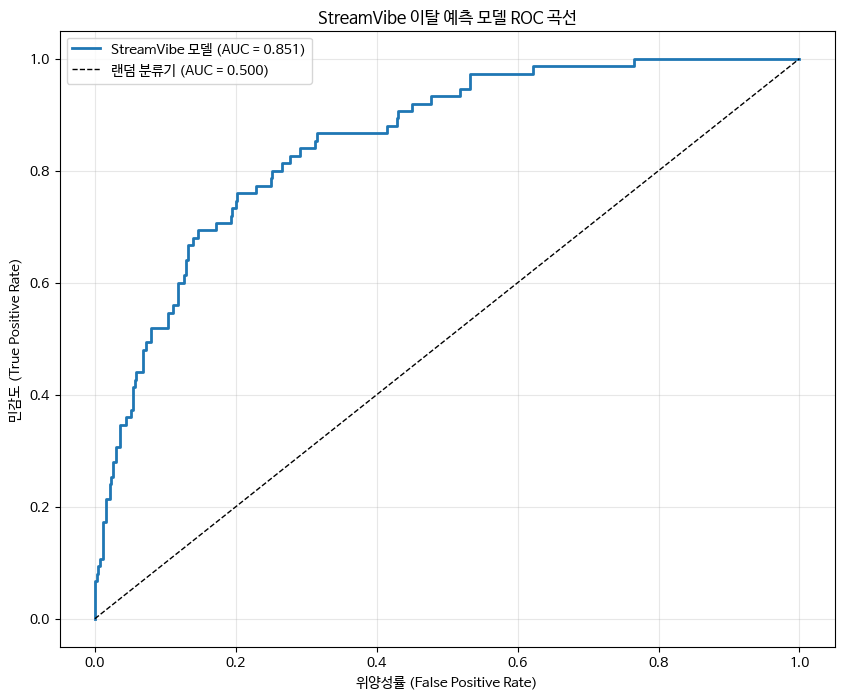

In [21]:
# ROC 곡선과 AUC 계산
fpr, tpr, thresholds = roc_curve(y_logistic, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 시각화
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'StreamVibe 모델 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='랜덤 분류기 (AUC = 0.500)')
plt.xlabel('위양성률 (False Positive Rate)')
plt.ylabel('민감도 (True Positive Rate)')
plt.title('StreamVibe 이탈 예측 모델 ROC 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC 성능 해석
if roc_auc > 0.9:
    performance_level = "탁월함 (업계 최고 수준)"
elif roc_auc > 0.8:
    performance_level = "우수함 (상용화 가능 수준)"
elif roc_auc > 0.7:
    performance_level = "양호함 (개선 여지 있음)"
else:
    performance_level = "부족함 (추가 개선 필요)"

print(f"📊 AUC 성능 평가: {roc_auc:.3f} → {performance_level}")

# 최적 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"🎯 최적 예측 임계값: {optimal_threshold:.3f}")
print(f"   이 임계값에서 민감도: {tpr[optimal_idx]:.3f}, 특이도: {1-fpr[optimal_idx]:.3f}")

plt.show()


📈 StreamVibe 이탈 예측 모델 성능 요약 (ROC 기반)
🎯 AUC (Area Under Curve) 해석
AUC = 0.851 → 우수함 (상용화 가능 수준)

이 값은 이탈 고객과 유지 고객을 85.1% 확률로 정확히 구분할 수 있음을 의미함

업계 기준으로도 경쟁력 있는 성능이며, 단순 랜덤 분류기(AUC = 0.5)보다 월등히 뛰어남

🔍 최적 예측 임계값 (Threshold)
최적 Threshold = 0.165 기준:

민감도 (Recall): 0.760 → 실제 이탈 고객 중 약 76.0%를 정확히 잡아냄

특이도 (Specificity): 0.798 → 유지 고객 중 약 79.8%를 정확히 유지로 판단함

이 값은 이탈 고객을 더 민감하게 감지하는 데 초점을 맞춘 결과임

(비용 손실이 큰 False Negative를 줄이기 위함으로 해석 가능)

✅ 비즈니스 시사점
현재 모델은 이탈 감지에 매우 유용하며, 특히 고위험군 선제 대응 캠페인에 효과적으로 활용 가능

향후 마케팅/고객 서비스에서 이 임계값(0.165)을 기준으로 이탈 위험도 분류 및 자동 대응 시스템 설계 가능

다만 임계값 조절에 따른 Precision 감소 가능성은 주의해야 하며, 비즈니스 전략에 맞춰 민감도 vs. 정밀도 간 균형 조정 필요

###📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략
🚨 현재 상황
전체 이탈률: 15.0%

고객 세그먼트 수: 3개

이탈 예측 모델 AUC: 0.851

모델 정확도: 87.0%

🎯 핵심 발견사항
고위험 세그먼트 특성

세그먼트 1: 이탈률 25.3%, 평균 시청시간 길고(13.9시간), 구독기간 매우 김(31.4개월), 콘텐츠 다양성은 중간 수준(5.6), 만족도는 평균 수준(7.2)

오랜 기간 사용한 충성 고객임에도 불구하고, 반복 콘텐츠 소비로 인한 콘텐츠 피로감이 이탈 요인일 가능성 높음

이탈 주요 예측 변수

만족도(score): 계수 -1.366 → 가장 강력한 이탈 방지 요인

구독기간: 계수 +0.599 → 장기 구독자일수록 이탈 가능성 증가

시청시간: 계수 -0.441 → 콘텐츠 활용도 높은 고객일수록 이탈 가능성 낮음

예측 가능한 이탈 고객

고위험 고객: 확률 0.7 초과 고객 11명 (2.2%)

중위험 고객: 0.3 ~ 0.7 사이 고객 69명 (13.8%)

고위험 + 중위험 고객 = 16.0% → 이탈 가능성 있는 고객 80명


💡 즉시 실행 가능한 대응 전략
선제적 고객 유지 전략

AUC 0.85 기반 예측 모델로 고위험 고객 실시간 감지 시스템 구축

고위험군 대상: 이탈 전 할인 쿠폰, 맞춤형 콘텐츠 추천, 고객 만족도 조사 실시

세그먼트별 맞춤 전략

세그먼트 1 (중위험): 장기 구독자 전용 프로그램 도입 (예: VIP 멤버십, 신규 콘텐츠 선공개)

세그먼트 2 (중위험): 만족도 낮고 콘텐츠 다양성 저조 → 개인화 큐레이션 강화

세그먼트 0 (저위험): 현재 전략 유지, 장기 고객 전환 유도

콘텐츠 전략 개선

장시간 시청 고객 중 이탈 고객 다수 → 과도한 반복 시청 패턴 확인

콘텐츠 다양성 높은 고객의 이탈률 낮음 → 큐레이션 다양성 강화 및 신작 추천 최적화


📈 예상 효과
이탈률 감소 목표: 15.0% → 10.0%로 5%p 개선

예상 매출 회복: 고객당 월 2만원 가정 시, 50명 유지 시 월 1천만원, 분기 기준 3천만원 회복

ROI: 유지 비용(고객당 5만원) 대비 손실 회피(20만원) 기준 → ROI 약 300% 기대


⏰ 실행 일정 (향후 3개월)

기간	   주요 실행 항목

1주차	     모델 임계값 확정(0.165), 고위험 고객 추출 시스템 구축

2~4주차 	 마케팅팀/고객팀 협업, 유지 캠페인 및 개인화 추천 설계 및 테스트

2개월차	  고위험군 우선 대응 → 반응률 분석 및 전략 조정, 콘텐츠 다양성 분석 착수

3개월차	  모든 세그먼트 대응 전략 실행, 이탈률 개선 측정 및 보고, 장기 전략 기획 수립


🔧 필요 리소스
인력: 데이터 분석가 1명, 마케팅 기획자 1명, CRM 운영자 1명 (총 3인)

예산: 고객 유지 비용 약 500만원 (쿠폰 및 마케팅 프로모션)

시스템: 실시간 예측 연동 가능한 CRM 개선, 알림 자동화 툴